## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [1]:
# can I do: output = !pip install ipympl?
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# this shows ipympl is not in the JaxEnv backend
!conda list ipympl

# packages in environment at /global/homes/x/xshuang/anaconda3:
#
# Name                    Version                   Build  Channel
ipympl                    0.9.2                    pypi_0    pypi


In [3]:
#!nvidia-smi

In [4]:
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel


import optax
tfd = tfp.distributions



# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/global/homes/a/andigu/.conda/envs/jaxenv/lib/python3.7/os.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/model.py


4

In [5]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

## show the simulated image -- use the TF demo

## How do I get the truth of the sampled parameters?

In [6]:
# note: here we're modeling the same demo system as in the paper

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

background_rms, exp_time = 0.2, 100


In [7]:
%matplotlib inline
# for the example system from lenstronomy

# truth = [[
#     {'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
#     {'gamma1': -0.01, 'gamma2': 0.03}
# ], [
#     {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.1, 'center_y': 0.0, 'Ie': 499.3695906504067}
# ], [
#     {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.09566681002252231, 'center_y': -0.0639623054267272, 'Ie': 149.58828877085668}
# ]]

# plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

# observed_img = np.load('./src/gigalens/assets/demo.npy')  # this is the lenstronomy example



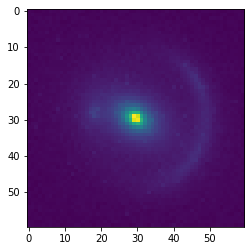

In [71]:
# Now I make up other systems

truth = [[
    {'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.0, 'center_y': 0.0, 'Ie': 500.}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.}
]]

simulated = lens_sim.simulate(truth)

plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



observed_img = simulated + np.random.normal(0, background_rms, simulated.shape) + np.random.poisson(simulated/exp_time, simulated.shape)
plt.imshow(observed_img)

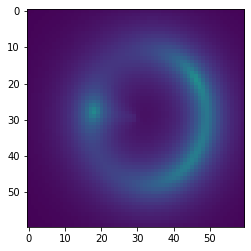

In [72]:
simulated = lens_sim.simulate([truth[0], [], truth[2]])

plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


In [49]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)

prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

Chi-square: 1.017286
1.0082746


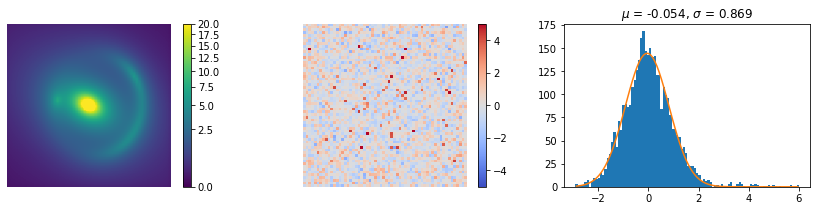

In [68]:
'''
When I re-simulate the example system in lenstronomy, I mostly recover everything,
but there are a few outlier points: the simulated observed_img has a few 4 sigma points.

Maybe lenstronomy did some kind of sigma clipping or percentile cut?

'''

from astropy import modeling

plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')

plt.subplot(132)
resid = observed_img - simulated
# background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)

norm_resid = resid/err_map

plt.imshow(norm_resid, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

plt.subplot(133)

bin_h, bins, _ = plt.hist(norm_resid.flatten(), bins=100)
x = (bins[:-1] + bins[1:])/2
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, x, bin_h)

plt.plot(x, fitted_model(x))
plt.title(r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(fitted_model.mean.value, fitted_model.stddev.value))


print(norm_resid.std())

In [51]:
map_samples = 300

map_steps = 500
transition_steps = 500

seed, lr_start, lr_end, pwr = 0, -1e-2, -1e-2/3, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

DEV version!!!


  0%|          | 0/500 [00:00<?, ?it/s]

In [52]:
# If I want to save the results
import pickle
from datetime import datetime
hyper_params = [map_steps, transition_steps, seed, lr_start, lr_end, pwr]

date = datetime.now().strftime("%Y_%m_%d-%H:%M")
with open(f"saved-maps/map_est_{date}.pickle", 'wb') as f:
    pickle.dump((map_estimate, chi2_hist, hyper_params), f)

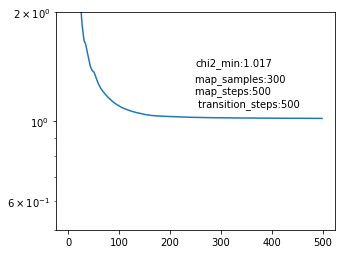

In [53]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

# map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min, hyper_p)
# plt.ylim(2.5, 6)
plt.ylim(0.5, 2)
plt.show()


In [54]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=map_samples), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

In [55]:
phys_params = prob_model.bij.forward(list(map_estimate.T))

params = phys_params
print(len(params[0][0]))
lens_params = params[0]


6


shapes of img_X, img_Y: (120, 120, 1) (120, 120, 1)
(120, 120, 1)
lens light component,  0
(120, 120, 300)
(120, 120, 300)


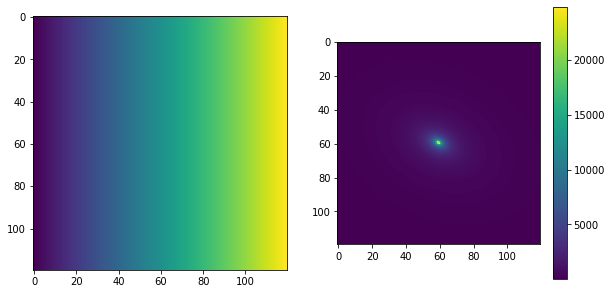

In [56]:
print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax2.imshow(lens_sim.img_Y[..., 0])



if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]



# insert a 0 at the front allows multiple light components to be concatenated
img_xh = jnp.zeros(lens_sim.img_X.shape)
print(img_xh.shape)
i = 0
for lightModel, p in zip(lens_sim.phys_model.lens_light, lens_light_params):
    print('lens light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
    img_xh += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
    i += 1
    
print(img_xh.shape)
lens_light_model = img_xh[..., 0].squeeze()

plt.imshow(lens_light_model)
plt.colorbar()

(120, 120, 1)
source light component,  0
(120, 120, 300)
(120, 120, 300)


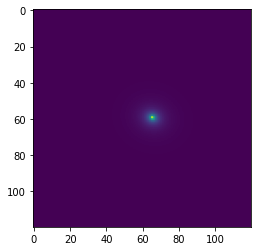

In [57]:
# I think this is the source light -- but it doesn't look right.  It's at the center

# insert a 0 at the front allows multiple light components to be concatenated
img_xh_s = jnp.zeros(lens_sim.img_X.shape)
print(img_xh_s.shape)
# img = jnp.concatenate((img, lightModel.light(beta_x, beta_y, **p)), axis=0)

i = 0
for lightModel, p in zip(lens_sim.phys_model.source_light, source_light_params):
    print('source light component, ', i)
    #print('beta x and y shapes:', beta_x.shape, beta_y.shape)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p).shape)
    img_xh_s += lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)
    i += 1
    
print(img_xh_s.shape)

# ---> this doesn't seem to agree with WS's way of doing it below
plt.imshow(img_xh_s[..., 0].squeeze())

In [58]:
# more readable form 
def extract_params(best_params):

    mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    shear_params = ['gamma1', 'gamma2']
    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')

# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
extract_params(best_params)
print('Compared with truth: \n')

extract_params(truth)
# chi2_ar = chi2_arr[-100:]
print('min chi2: {:4.3f}'.format(chi2_arr.min()))

Lens mass params (2 sets):
theta_E= 1.097  gamma= 1.912  e1   = 0.091  e2   = 0.109  center_x= 0.002  center_y= 0.005  
gamma1=-0.033  gamma2= 0.024  

Lens light params(1 sets):
R_sersic= 0.772  n_sersic= 2.407  e1   = 0.094  e2   = 0.144  center_x=-0.002  center_y=-0.001  Ie   =545.967  

Source light params(1 sets):
R_sersic= 0.266  n_sersic= 1.404  e1   = 0.053  e2   = 0.018  center_x= 0.236  center_y= 0.004  Ie   =168.806  

Compared with truth: 

Lens mass params (2 sets):
theta_E= 1.100  gamma= 1.800  e1   = 0.100  e2   = 0.100  center_x= 0.000  center_y= 0.000  
gamma1=-0.010  gamma2= 0.030  

Lens light params(1 sets):
R_sersic= 0.800  n_sersic= 2.500  e1   = 0.095  e2   = 0.148  center_x= 0.000  center_y= 0.000  Ie   =500.000  

Source light params(1 sets):
R_sersic= 0.250  n_sersic= 1.500  e1   = 0.000  e2   = 0.000  center_x= 0.200  center_y= 0.000  Ie   =150.000  

min chi2: 1.017


Chi-square: 1.017286


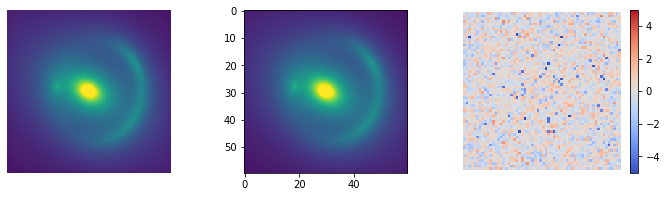

In [59]:
# compare best-fit parameters with observed image
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(132)
simulated = lens_sim.simulate(best_params)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(133)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
print('Chi-square:', np.mean((resid/err_map)**2))
plt.axis('off')
plt.colorbar()

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

lens params: [{'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.01, 'gamma2': 0.03}]
source light params: [{'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.0}]
(60, 60)


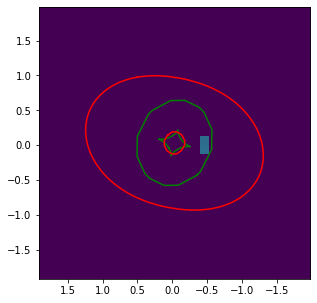

In [61]:
delta_pix=0.065
num_pix = 60

lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
x = lens_sim_t.simulate([[], truth[2], []])
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )


scale_extent = 1.

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# source_img = np.rot90(np.rot90(x))
source_img = x
extent = (num_pix*delta_pix), -(num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)


lens params: [{'theta_E': 1.1, 'gamma': 1.8, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': -0.01, 'gamma2': 0.03}]
source light params: [{'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.2, 'center_y': 0.0, 'Ie': 150.0}]
(100,)


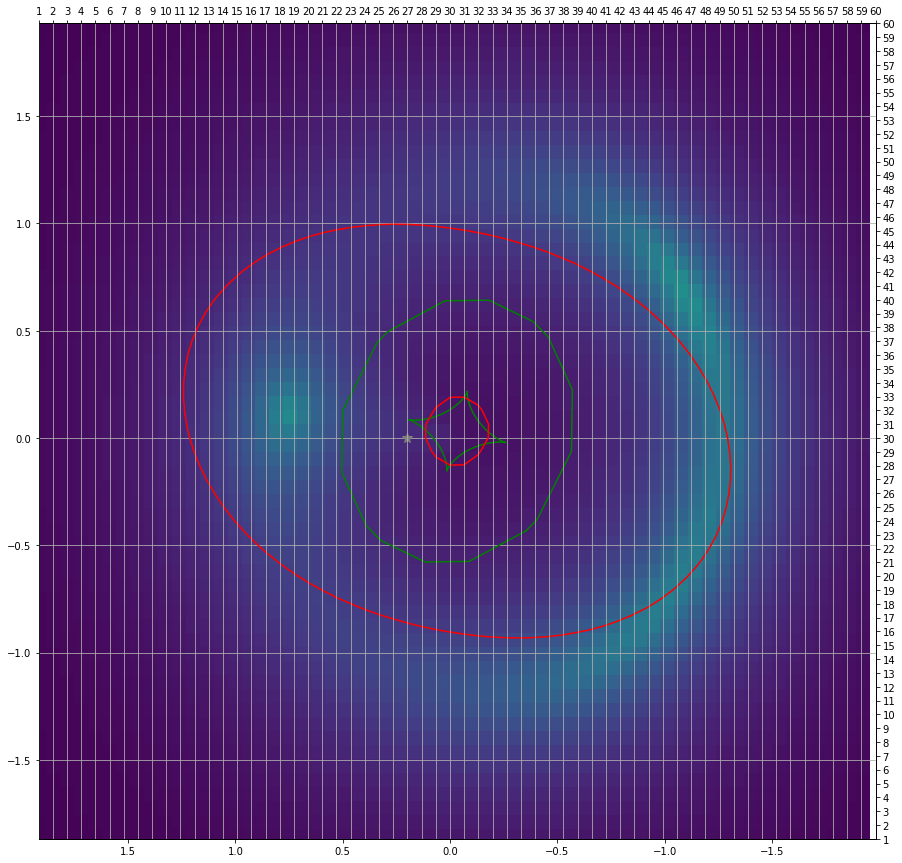

In [148]:
delta_pix=0.065
num_pix = 60

lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([[], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

scale_extent = 2.0

extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
         -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# source_img = np.rot90(np.rot90(source_img))
# extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
ax.grid(axis='y')


ax2 = ax.twinx().twiny() #here is the trick!
# ax2.tick_params(axis='both', labelcolor='blue')
ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# Major ticks
ax2.set_xticks(np.arange(0, 60, 1))
ax2.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax2.set_xticklabels(np.arange(1, 61, 1))
ax2.set_yticklabels(np.arange(1, 61, 1))
ax2.grid(which='major')
# ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

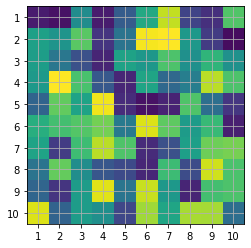

In [140]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

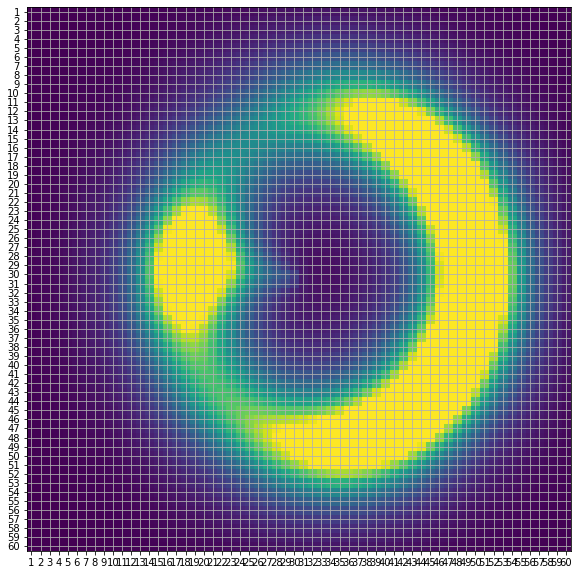

In [146]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

In [102]:
truth[2][0]

{'R_sersic': 0.25,
 'n_sersic': 1.5,
 'e1': 0.0,
 'e2': 0.0,
 'center_x': 0.2,
 'center_y': 0.0,
 'Ie': 150.0}

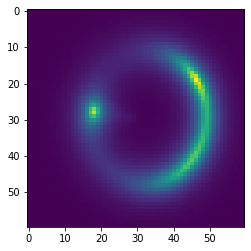

In [77]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

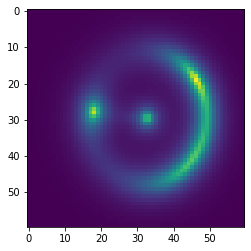

In [79]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

In [ ]:
vs = 0.05
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=lens_params, with_caustics=True, fast_caustic=True, coord_inverse=False, deltaPix=0.015/scale, numPix=int(275*scale))
size = 58
scale_extent = 1.8

imnorm = mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)
extent = (size*delta_pix)/scale_extent, -(size*delta_pix)/scale_extent, -(size*delta_pix)/scale_extent, (size*delta_pix)/scale_extent,

# I do the same as WS -- rotating the image by 180 deg relative to the caustic.  I'm not sure why.
src_model = np.rot90(np.rot90(img_sp_tot[..., 0]))

#### plot model for arc together with data
arcs_model_rot = np.rot90(np.rot90(arcs_model))
ax.imshow(src_model+arcs_model_rot, extent=extent, norm=imnorm, cmap='plasma')

source light component,  0
(120, 120, 100)
(120, 120, 100)


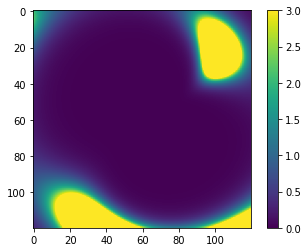

In [47]:
# ---> if I apply deriv to to this, I should get the source plane

# ---> but I should know what happened in lightModel.light()!!!!

# insert a 0 at the front allows multiple light components to be concatenated


beta_x, beta_y = lens_sim._beta(lens_params)

img_xh_s = jnp.zeros(lens_sim.img_X.shape)

# img = jnp.concatenate((img, lightModel.light(beta_x, beta_y, **p)), axis=0)

i = 0
for lightModel, p in zip(lens_sim.phys_model.source_light, source_light_params):
    # print('source light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print('source light component, ', i)
    # print(p)
    # img = jnp.concatenate((img, lightModel.light(lens_sim.img_X, lens_sim.img_Y, **p)), axis=0)
    print(lightModel.light(beta_x, beta_y, **p).shape)

    img_xh_s += lightModel.light(beta_x, beta_y, **p)

    i += 1
print(img_xh_s.shape)

arcs_model = img_xh_s[..., 0].squeeze()
plt.imshow(arcs_model, vmin=0, vmax=3)
plt.colorbar()



## Next: add cautic and critical curves -- reproduce one of the four archetypes

## VI and HMC steps

In [ ]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=100, num_steps=100)
# qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

In [ ]:
plt.plot(loss_hist)

In [ ]:
samples = model_seq.HMC(qz, num_burnin_steps=20, num_results=70)

In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)

In [ ]:
rhat